In [1]:
#==========================================
# Title:  Options Price Predictor using an LSTM Model
# Author: Vachan
# Email : vachan@iitb.ac.in
#==========================================

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from scipy.stats import norm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU

In [3]:
excel_file = pd.ExcelFile("ASIANPAINT_Dataset.xlsx")
sheets_ce = ['CE2017', 'CE2018', 'CE2019', 'CE2020']
sheets_pe = ['PE2017', 'PE2018', 'PE2019', 'PE2020']
ce_data = pd.concat([excel_file.parse(sheet) for sheet in sheets_ce], ignore_index=True).dropna().reset_index().drop(columns=['index'])
pe_data = pd.concat([excel_file.parse(sheet) for sheet in sheets_pe], ignore_index=True).dropna().reset_index().drop(columns=['index'])

In [4]:
# Hyperparams
n_batch = 50
n_epochs = 20

In [5]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation="relu", return_sequences=True, input_shape=input_shape),
        LSTM(50, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [6]:
ce_data.strike_price = ce_data.strike_price
ce_data.underlying_value = ce_data.underlying_value

In [7]:
pe_data.strike_price = pe_data.strike_price 
pe_data.underlying_value = pe_data.underlying_value 

In [8]:
X_ce_train, X_ce_test, y_ce_train, y_ce_test = train_test_split(ce_data.drop(columns=['Date', 'Expiry']), ce_data.drop(columns=['Date', 'Expiry', 't','strike_price', 'underlying_value', 'sigma', 'r']), test_size=0.20, random_state=42)
X_pe_train, X_pe_test, y_pe_train, y_pe_test = train_test_split(pe_data.drop(columns=['Date', 'Expiry']), pe_data.drop(columns=['Date', 'Expiry', 't','strike_price', 'underlying_value', 'sigma', 'r']), test_size=0.20, random_state=42)

In [9]:
def black_scholes_call(S, K, T, r, sigma, instrument):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if instrument=="Call":
     price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
     price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

In [10]:
# Extract necessary columns from the test set
S1 = X_ce_test['underlying_value'] # rescaled 
K1 = X_ce_test['strike_price']    # rescaled
T1 = X_ce_test['t']/365           # always measured in years
r1 = X_ce_test['r']
sigma1 = X_ce_test['sigma']

# Compute Black-Scholes predictions
bs_predictions_call = black_scholes_call(S1, K1, T1, r1, sigma1, "Call")



In [11]:
# Compute RMSE for Black-Scholes predictions
bs_rmse_call = mean_squared_error(y_ce_test, bs_predictions_call, squared=False)
bs_rmse_call


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


100.08241410017231

In [12]:
# Extract necessary columns from the test set
S2 = X_pe_test['underlying_value'] # rescaled 
K2 = X_pe_test['strike_price']    # rescaled
T2 = X_pe_test['t']/365            # always measured in years
r2 = X_pe_test['r']
sigma2 = X_pe_test['sigma']

# Compute Black-Scholes predictions
bs_predictions_put = black_scholes_call(S2, K2, T2, r2, sigma2, "Put")



In [13]:
# Compute RMSE for Black-Scholes predictions
bs_rmse_put = mean_squared_error(y_pe_test, bs_predictions_put, squared=False)
bs_rmse_put


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


88.54763830543305

In [14]:
sequence_length = 1  # Set this based on your requirement
X_ce_train = X_ce_train.values.reshape(-1, sequence_length, X_ce_train.shape[1])
X_ce_test = X_ce_test.values.reshape(-1, sequence_length, X_ce_test.shape[1])
X_pe_train = X_pe_train.values.reshape(-1, sequence_length, X_pe_train.shape[1])
X_pe_test = X_pe_test.values.reshape(-1, sequence_length, X_pe_test.shape[1])

In [15]:
# CE Model
input_shape_ce = (sequence_length, X_ce_train.shape[2])
ce_model = build_lstm_model(input_shape=input_shape_ce)
history_call = ce_model.fit(X_ce_train, y_ce_train, n_batch, n_epochs, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

C:\Users\vacha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3125.9536 - val_loss: 37.4072
Epoch 2/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 35.4933 - val_loss: 13.1778
Epoch 3/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 12.5335 - val_loss: 5.3528
Epoch 4/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.1008 - val_loss: 1.6490
Epoch 5/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4527 - val_loss: 0.2835
Epoch 6/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2073 - val_loss: 0.0438
Epoch 7/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9222 - val_loss: 0.2788
Epoch 8/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9802 - val_loss: 0.0485
Epoch 9/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9028 - val_loss: 0.0011
Epoch 10/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3225 - val_loss: 7.3907e-04
Epoch 11/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1850 - val_loss: 3.6190e-04
Epoch 12/20
17

In [17]:
# PE Model
input_shape_pe = (sequence_length, X_pe_train.shape[2])
pe_model = build_lstm_model(input_shape=input_shape_pe)
history_put = pe_model.fit(X_pe_train, y_pe_train, n_batch, n_epochs, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

Epoch 1/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1312.4977 - val_loss: 66.7558
Epoch 2/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 35.1230 - val_loss: 5.3580
Epoch 3/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.6030 - val_loss: 0.8189
Epoch 4/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5349 - val_loss: 0.7228
Epoch 5/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5859 - val_loss: 0.0213
Epoch 6/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5491 - val_loss: 0.0352
Epoch 7/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5708 - val_loss: 0.0368
Epoch 8/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4948 - val_loss: 0.0255
Epoch 9/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2262 - val_loss: 0.0679
Epoch 10/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6068 - val_loss: 0.0024
Epoch 11/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1638 - val_loss: 0.0704
Epoch 12/20
1772/1772 ━━

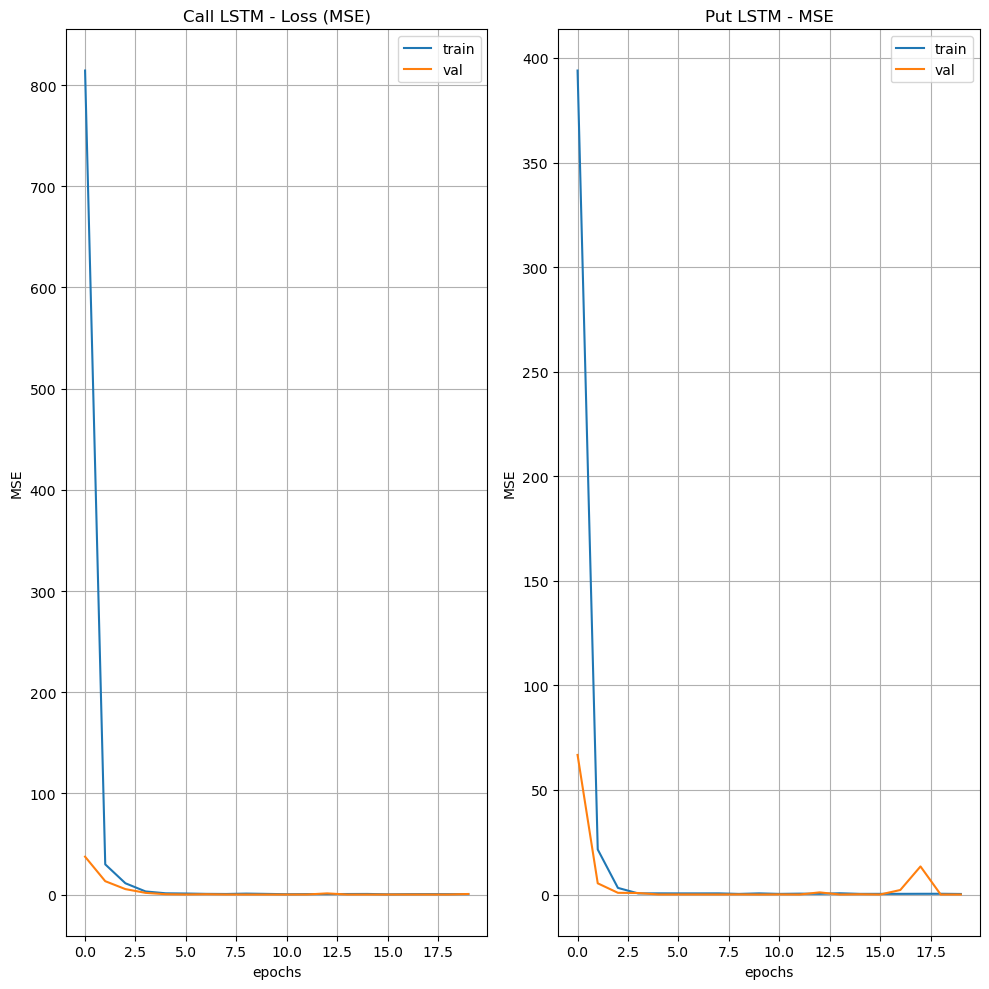

In [18]:
plt.figure(figsize=(10,10))


plt.subplot(1,2,1)
plt.plot(list(range(n_epochs)), history_call.history["loss"], label="train")
plt.plot(list(range(n_epochs)), history_call.history["val_loss"], label="val")
plt.title("Call LSTM - Loss (MSE)")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(n_epochs)), history_put.history["loss"], label="train")
plt.plot(list(range(n_epochs)), history_put.history["val_loss"], label="val")
plt.title("Put LSTM - MSE")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()

plt.tight_layout()
plt.grid()
plt.savefig('LSTM_model_learning_curve.png')

In [19]:
# Save models
ce_model.save('ce_price_model.h5')
pe_model.save('pe_price_model.h5')

In [20]:
y_ce_pred =ce_model.predict(X_ce_test)
y_pe_pred =ce_model.predict(X_pe_test)

700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [21]:
print("LSTM Call model RMSE:\t",mean_squared_error(y_ce_pred, y_ce_test)**0.5)
print("LSTM Put RMSE:\t",mean_squared_error(y_pe_pred, y_pe_test)**0.5)

LSTM Call model RMSE:	 0.72793263041278
LSTM Put RMSE:	 2.635699487841996


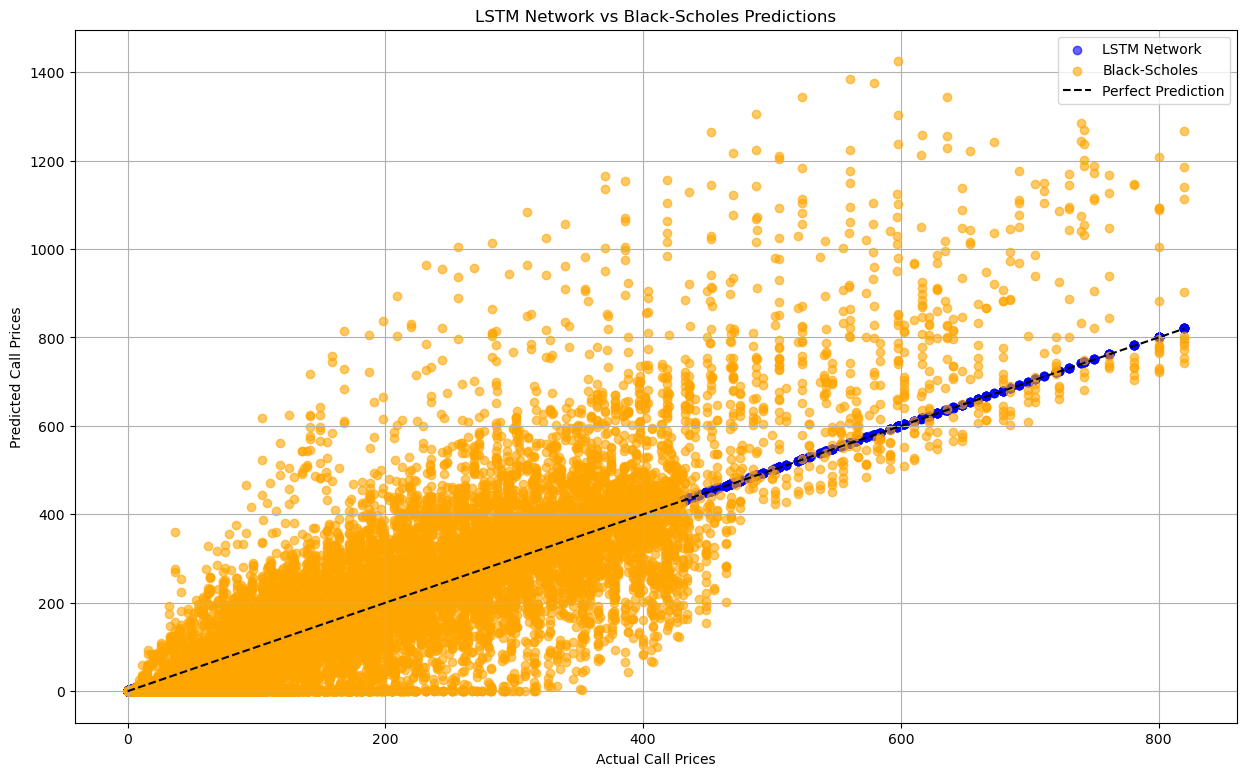

<Figure size 640x480 with 0 Axes>

In [39]:
plt.figure(figsize=(15, 9))
# Scatter plot for NN predictions
plt.scatter(y_ce_test, y_ce_pred, alpha=0.6, label='LSTM Network', color='blue')
# Scatter plot for Black-Scholes predictions
plt.scatter(y_ce_test, bs_predictions_call, alpha=0.6, label='Black-Scholes', color='orange')

plt.plot([y_ce_test.min(), y_ce_test.max()], [y_ce_test.min(), y_ce_test.max()], 'k--', label="Perfect Prediction")
plt.xlabel("Actual Call Prices")
plt.ylabel("Predicted Call Prices")
plt.legend()
plt.title("LSTM Network vs Black-Scholes Predictions")
plt.grid()
plt.show()
plt.savefig('Call_LSTM_model_Vs_BlackScholes.png')

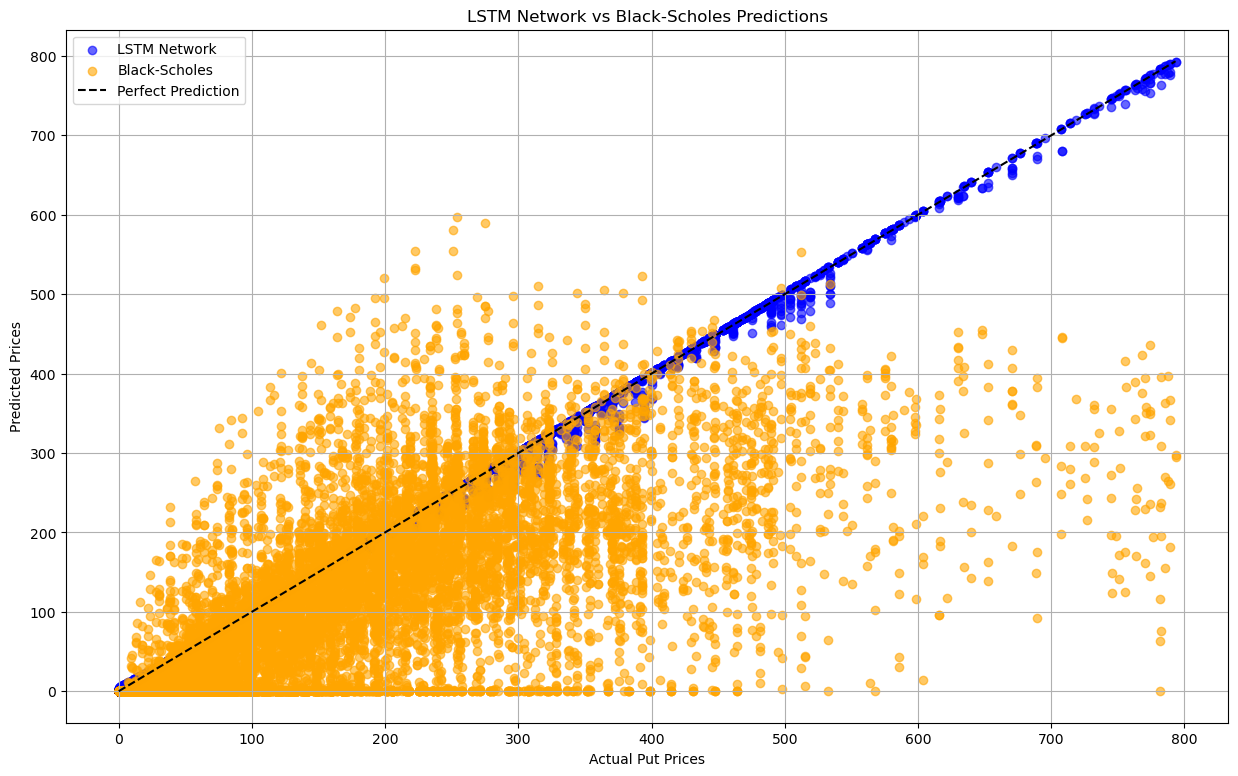

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(15, 9))
# Scatter plot for NN predictions
plt.scatter(y_pe_test, y_pe_pred, alpha=0.6, label='LSTM Network', color='blue')
# Scatter plot for Black-Scholes predictions
plt.scatter(y_pe_test, bs_predictions_put, alpha=0.6, label='Black-Scholes', color='orange')

plt.plot([y_pe_test.min(), y_pe_test.max()], [y_pe_test.min(), y_pe_test.max()], 'k--', label="Perfect Prediction")
plt.xlabel("Actual Put Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("LSTM Network vs Black-Scholes Predictions")
plt.grid()
plt.show()
plt.savefig('Put_LSTM_model_Vs_BlackScholes.png')